In [2]:
import numpy as np
import torch
import time
import pandas as pd
import matplotlib.pyplot as plt
import cupy as cp

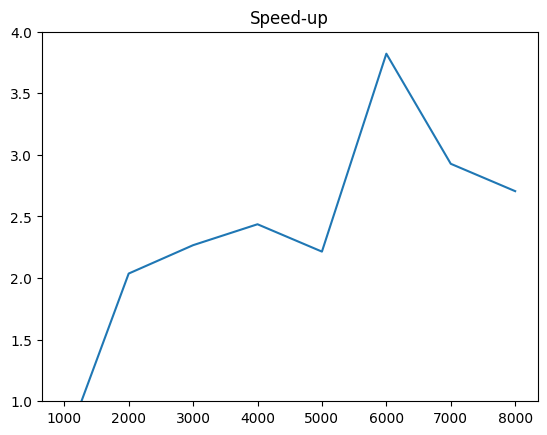

In [8]:
### 作業一

record = {}
#cpu_device = torch.device('cpu')
#gpu_device = torch.device('cuda:0')


def calculate(size):

  # 生成隨機矩陣和向量
  A = torch.rand(n, n) #這個不用每次都算
  b = torch.rand(n, 1)

  # 在 CPU 上運行
  start_time = time.time()
  result_cpu = np.linalg.solve(A, b)
  execution_time = time.time() - start_time
  cpu_time = execution_time
  #print(cpu_time)

  # 在 GPU 上運行
  start_time = time.time()
  result_gpu = torch.linalg.solve(A, b)
  execution_time = time.time() - start_time
  gpu_time = execution_time
  #print(gpu_time)
  return cpu_time/gpu_time


for n in range(1000,9000,1000):
  record[n] = calculate(n)


df = pd.DataFrame({'value': record})
df.plot(y='value', legend=False, title='Speed-up')
plt.show()

(1.0, 4.0)

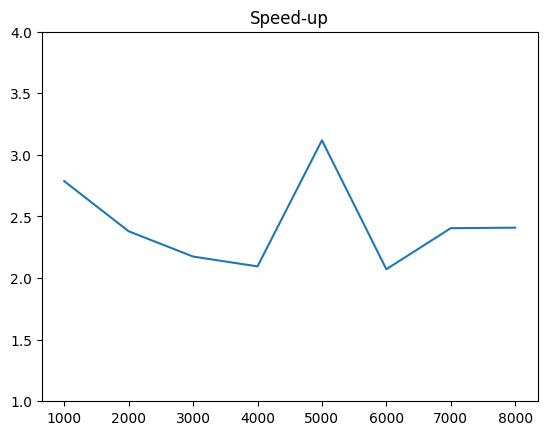

In [ ]:
df.plot(y='value', legend=False, title='Speed-up')
plt.ylim(1,4)


CPU FFT Time: 0.000192 seconds
GPU FFT Time: 0.001218 seconds
CPU FFT Time: 0.000085 seconds
GPU FFT Time: 0.000339 seconds
CPU FFT Time: 0.000141 seconds
GPU FFT Time: 0.000369 seconds
CPU FFT Time: 0.000245 seconds
GPU FFT Time: 0.000445 seconds
CPU FFT Time: 0.000384 seconds
GPU FFT Time: 0.000330 seconds
CPU FFT Time: 0.000701 seconds
GPU FFT Time: 0.000458 seconds
CPU FFT Time: 0.001434 seconds
GPU FFT Time: 0.000683 seconds
CPU FFT Time: 0.002763 seconds
GPU FFT Time: 0.001144 seconds
CPU FFT Time: 0.008208 seconds
GPU FFT Time: 0.001737 seconds
CPU FFT Time: 0.015748 seconds
GPU FFT Time: 0.004160 seconds


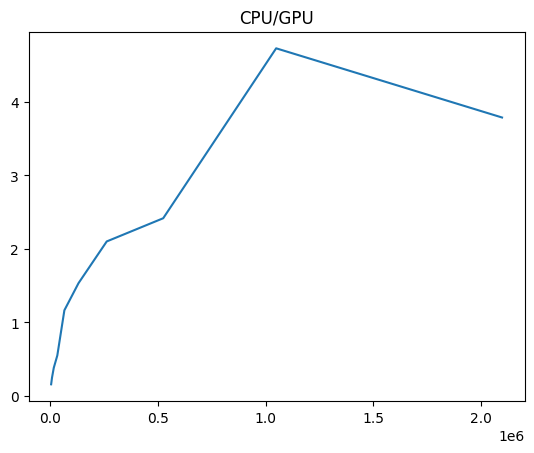

In [ ]:
record_FFT = {}

for m in range(12,22):
    n = 2**m
    T = np.random.rand(n, 1)

    # CPU FFT
    start_time = time.time()
    F_cpu = np.fft.fft(T)
    cpu_time = time.time() - start_time

    # GPU FFT
    start_time = time.time()
    F_gpu = cp.fft.fft(cp.array(T))
    gpu_time = time.time() - start_time

    #print("CPU FFT Time: {:.6f} seconds".format(cpu_time))
    #print("GPU FFT Time: {:.6f} seconds".format(gpu_time))
    record_FFT[n] = cpu_time/gpu_time

df = pd.DataFrame({'value': record_FFT})
df.plot(y='value', legend=False, title='CPU/GPU')
plt.show()

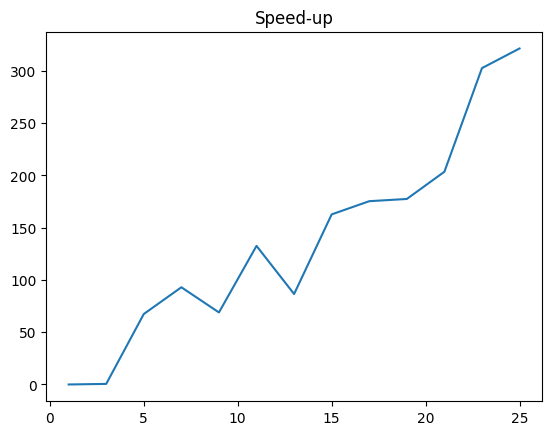

In [ ]:
### 作業三(1)

record_default_rate = {}


# 設定相關參數
d = -1
rho = 0.25
Nrepl = 750000

for n in range(1,26,2):

  start_time_cpu = time.time()
  Sigma = rho * np.ones((n, n)) + (1 - rho) * np.eye(n)
  T_cpu = np.linalg.cholesky(Sigma)
  X_MC_cpu = np.random.randn(Nrepl, n) @ T_cpu.T
  MC_cpu = np.prod(1 * (X_MC_cpu < d), axis=1)
  P_MC_cpu = np.mean(MC_cpu)
  SE_MC_cpu = np.std(MC_cpu) / np.sqrt(Nrepl)
  time_cpu = time.time() - start_time_cpu


  start_time_gpu = time.time()
  device = cp.cuda.Device(0)  # 選擇 GPU 設備，索引可能需要調整
  device.use()
  Sigma_gpu = rho * cp.ones((n, n)) + (1 - rho) * cp.eye(n)
  T_gpu = cp.linalg.cholesky(Sigma_gpu)
  X_MC_gpu = cp.random.randn(Nrepl, n) @ T_gpu.T
  MC_gpu = cp.prod(1 * (X_MC_gpu < d * cp.ones((Nrepl, n))), axis=1)
  P_MC_gpu = cp.mean(MC_gpu)
  SE_MC_gpu = cp.std(MC_gpu) / cp.sqrt(Nrepl)
  #cp.cuda.Stream.null.synchronize() # 等待 GPU 完成操作
  time_gpu = time.time() - start_time_gpu

  record_default_rate[n] = time_cpu/time_gpu

df = pd.DataFrame({'value': record_default_rate})
df.plot(y='value', legend=False, title='Speed-up')
plt.show()

In [7]:
### 作業三(2)


NSteps = 100
Nrepl = 100000
T = 1
r = 0.05
sigma = 0.3
S0 = 50
K = 55

# CPU
start_time_cpu = time.time()
dt = T / NSteps
nudt = (r - 0.5 * sigma**2) * dt
sqdt = np.sqrt(dt)
sidt = sigma * sqdt
RandMat_cpu = np.random.randn(Nrepl, NSteps)
Increments_cpu = nudt + sidt * RandMat_cpu
LogPaths_cpu = np.cumsum(np.concatenate([np.log(S0) * np.ones((Nrepl, 1)), Increments_cpu], axis=1), axis=1)
SPaths_cpu = np.exp(LogPaths_cpu)

SPaths_cpu[:, 0] = 0
CashFlows_cpu = np.exp(-r * T) * np.maximum(0, SPaths_cpu[:, -1] - K)


price_cpu = np.mean(CashFlows_cpu)
var_cpu = np.cov(CashFlows_cpu, rowvar=False) / Nrepl
std_cpu = np.sqrt(var_cpu)


elapsed_time_cpu = time.time() - start_time_cpu



start_time_gpu = time.time()

# GPU
dt_gpu = torch.tensor(dt)
nudt_gpu = torch.tensor(nudt)
sqdt_gpu = torch.tensor(sqdt)
sidt_gpu = torch.tensor(sidt)


RandMat = torch.randn(Nrepl, NSteps, device='cuda')  # 在 GPU 上產生隨機數
Increments = nudt_gpu + sidt_gpu * RandMat
LogPaths = torch.cumsum(torch.cat([torch.log(torch.tensor(S0)) * torch.ones((Nrepl, 1), device='cuda'), Increments], dim=1), dim=1)
SPaths = torch.exp(LogPaths)
SPaths[:, 0] = 0
CashFlows = torch.exp(torch.tensor(-r * T)) * torch.maximum(torch.zeros(Nrepl, device='cuda'), SPaths[:, -1] - K)


price_gpu = CashFlows.mean()
var_gpu = torch.var(CashFlows) / Nrepl
std_gpu = torch.sqrt(var_gpu)
elapsed_time_gpu = time.time() - start_time_gpu



print("Elapsed Time (CPU): {:.6f} seconds".format(elapsed_time_cpu))
print("Elapsed Time (GPU): {:.6f} seconds".format(elapsed_time_gpu))



Elapsed Time (GPU): 0.138054 seconds
Elapsed Time (CPU): 0.395682 seconds
